In [1]:
import sys
import os

# 1. Verify Environment
print(f"Python Executable: {sys.executable}")

if "anaconda" in sys.executable.lower():
    print("\n⚠️ WARNING: You are likely using the GLOBAL ANACONDA environment.")
    print("If this fails, please switch the kernel to '.venv' (Top Right -> Select Kernel -> Python Environments -> .venv)")
else:
    print("\n✅ SUCCESS: You are using a local virtual environment!")

# 2. DLL Conflict Fixes (Must be set before importing torch)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["MKL_THREADING_LAYER"] = "GNU"

Python Executable: c:\Users\sajal\Downloads\PEST PROJECT\.venv\Scripts\python.exe

✅ SUCCESS: You are using a local virtual environment!


In [2]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

print(f"Torch Version: {torch.__version__}")

c:\Users\sajal\Downloads\PEST PROJECT\.venv\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\sajal\Downloads\PEST PROJECT\.venv\Lib\site-packages\libpyg.pyd
  import torch_geometric.typing
c:\Users\sajal\Downloads\PEST PROJECT\.venv\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\sajal\Downloads\PEST PROJECT\.venv\Lib\site-packages\torch_scatter\_version_cpu.pyd
  import torch_geometric.typing
c:\Users\sajal\Downloads\PEST PROJECT\.venv\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\sajal\Downloads\PEST PROJECT\.venv\Lib\site-packages\torch_cluster\_version_cpu.pyd
  import torch_geometric.t

Torch Version: 2.10.0+cpu


In [3]:
import pandas as pd
import numpy as np

# -----------------------------
# 1. Load Dataset
# -----------------------------
if os.path.exists("merged_output.csv"):
    df = pd.read_csv("merged_output.csv")
    
    # -----------------------------
    # 2. Convert Date
    # -----------------------------
    df["CreatedOn"] = pd.to_datetime(df["CreatedOn"], errors="coerce")
    df = df.dropna(subset=["CreatedOn"])
    
    # -----------------------------
    # 3. Create Year-Month Column
    # -----------------------------
    df["year_month"] = df["CreatedOn"].dt.to_period("M")

    # -----------------------------
    # 4. Monthly Aggregation
    # -----------------------------
    monthly_df = (
        df.groupby(["district", "year_month"])
        .agg({
            "pest_count": "sum",
            "latitude": "first",
            "longitude": "first"
        })
        .reset_index()
    )

    # Convert Period to timestamp
    monthly_df["year_month"] = monthly_df["year_month"].dt.to_timestamp()

    # -----------------------------
    # 5. Create District Index Mapping
    # -----------------------------
    district_list = monthly_df["district"].unique()
    district_to_idx = {district: idx for idx, district in enumerate(district_list)}

    monthly_df["district_id"] = monthly_df["district"].map(district_to_idx)

    # -----------------------------
    # 6. Sort Properly
    # -----------------------------
    monthly_df = monthly_df.sort_values(["year_month", "district_id"])

    # -----------------------------
    # 7. Save Processed File
    # -----------------------------
    monthly_df.to_csv("monthly_spatiotemporal_data.csv", index=False)

    print("Preprocessing Complete")
    print("Total Districts:", len(district_list))
    print("Total Time Steps:", monthly_df["year_month"].nunique())
else:
    print("Skipping preprocessing (merged_output.csv not found).")

Preprocessing Complete
Total Districts: 543
Total Time Steps: 57


In [4]:
from sklearn.neighbors import NearestNeighbors

# -----------------------------
# 1. Load Monthly Data
# -----------------------------
if os.path.exists("monthly_spatiotemporal_data.csv"):
    df = pd.read_csv("monthly_spatiotemporal_data.csv")

    # -----------------------------
    # 2. Get Unique Districts
    # -----------------------------
    district_df = df[["district_id", "latitude", "longitude"]].drop_duplicates()
    district_df = district_df.sort_values("district_id")

    coords = district_df[["latitude", "longitude"]].values
    num_nodes = len(coords)

    print("Total Nodes:", num_nodes)

    # -----------------------------
    # 3. K-Nearest Neighbors
    # -----------------------------
    K = 8

    # Use Haversine distance
    # Convert degrees to radians
    coords_rad = np.radians(coords)

    nbrs = NearestNeighbors(
        n_neighbors=K + 1,  # +1 because first neighbor is itself
        metric="haversine"
    )

    nbrs.fit(coords_rad)

    distances, indices = nbrs.kneighbors(coords_rad)

    # Convert haversine distance (radians) to kilometers
    earth_radius_km = 6371
    distances = distances * earth_radius_km

    # -----------------------------
    # 4. Build Edge Index and Weights
    # -----------------------------
    edge_index = []
    edge_weight = []

    for i in range(num_nodes):
        for j in range(1, K + 1):  # skip self-loop at index 0
            neighbor = indices[i][j]
            dist = distances[i][j]

            if dist == 0:
                continue

            weight = 1.0 / dist

            edge_index.append([i, neighbor])
            edge_weight.append(weight)

    # Convert to numpy
    edge_index = np.array(edge_index).T  # shape [2, num_edges]
    edge_weight = np.array(edge_weight)

    print("Total Edges:", edge_index.shape[1])

    # -----------------------------
    # 5. Save Files
    # -----------------------------
    np.save("edge_index.npy", edge_index)
    np.save("edge_weight.npy", edge_weight)

    district_df.to_csv("district_coordinates.csv", index=False)

    print("Graph Construction Complete")

Total Nodes: 543
Total Edges: 4306
Graph Construction Complete


In [5]:
# -----------------------------
# Custom MPNN Layer
# -----------------------------
class DistanceWeightedMPNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(DistanceWeightedMPNN, self).__init__(aggr='add')
        self.linear = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):
        # Check if self-loops are already added or not
        # Only add self-loops if needed
        if edge_weight is not None:
             # FIX: In newer torch_geometric, argument is 'edge_attr' not 'edge_weight'
             edge_index, edge_weight = add_self_loops(
                edge_index, 
                edge_attr=edge_weight, 
                fill_value=1.0,
                num_nodes=x.size(0)
            )

        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_j, edge_weight):
        return edge_weight.view(-1, 1) * x_j

    def update(self, aggr_out):
        return self.linear(aggr_out)

# -----------------------------
# Spatio-Temporal Model
# -----------------------------
class SpatioTemporalMPNN(nn.Module):
    def __init__(self, num_nodes, in_channels, hidden_dim):
        super(SpatioTemporalMPNN, self).__init__()

        self.mpnn = DistanceWeightedMPNN(in_channels, hidden_dim)

        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, 1)

        self.num_nodes = num_nodes

    def forward(self, x_seq, edge_index, edge_weight):
        """
        x_seq shape:
        [time_steps, num_nodes, in_channels]
        """

        spatial_embeddings = []

        for t in range(x_seq.shape[0]):
            x_t = x_seq[t]
            h = self.mpnn(x_t, edge_index, edge_weight)
            spatial_embeddings.append(h)

        spatial_embeddings = torch.stack(spatial_embeddings)
        # shape: [time_steps, num_nodes, hidden_dim]

        spatial_embeddings = spatial_embeddings.permute(1, 0, 2)
        # shape: [num_nodes, time_steps, hidden_dim]

        lstm_out, _ = self.lstm(spatial_embeddings)

        final_out = lstm_out[:, -1, :]
        predictions = self.fc(final_out)

        return predictions.squeeze()

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
# from model_spatiotemporal_mpnn import SpatioTemporalMPNN  <-- REMOVE THIS IMPORT

# -----------------------------
# 1. Load Data
# -----------------------------
df = pd.read_csv("monthly_spatiotemporal_data.csv")

edge_index = torch.tensor(np.load("edge_index.npy"), dtype=torch.long)
edge_weight = torch.tensor(np.load("edge_weight.npy"), dtype=torch.float)

num_nodes = df["district_id"].nunique()

# -----------------------------
# 2. Create Time Sorted Matrix
# -----------------------------
df = df.sort_values(["year_month", "district_id"])

months = df["year_month"].unique()
num_months = len(months)

# Create matrix [months, nodes]
pest_matrix = np.zeros((num_months, num_nodes))

for i, month in enumerate(months):
    temp = df[df["year_month"] == month]
    pest_matrix[i, temp["district_id"].values] = temp["pest_count"].values

# -----------------------------
# 3. Normalize
# -----------------------------
scaler = MinMaxScaler()
pest_matrix = scaler.fit_transform(pest_matrix)

# Convert to tensor
pest_tensor = torch.tensor(pest_matrix, dtype=torch.float)

# -----------------------------
# 4. Create Sliding Window
# -----------------------------
window_size = 6

X_list = []
y_list = []

for i in range(num_months - window_size):
    X_list.append(pest_tensor[i:i+window_size])
    y_list.append(pest_tensor[i+window_size])

# Check if data is sufficient
if len(X_list) == 0:
    print("Not enough data points for the given window size!")
else:
    X = torch.stack(X_list)   # [samples, time, nodes]
    y = torch.stack(y_list)   # [samples, nodes]

    # Rearrange X to [samples, time, nodes, features]
    X = X.unsqueeze(-1)

    # -----------------------------
    # 5. Train-Test Split
    # -----------------------------
    train_size = int(0.8 * X.shape[0])

    X_train = X[:train_size]
    y_train = y[:train_size]

    X_test = X[train_size:]
    y_test = y[train_size:]

    # -----------------------------
    # 6. Model Init
    # -----------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Use the class defined in the PREVIOUS cell directly
    model = SpatioTemporalMPNN(
        num_nodes=num_nodes,
        in_channels=1,
        hidden_dim=32
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # -----------------------------
    # 7. Training Loop
    # -----------------------------
    epochs = 250

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for i in range(X_train.shape[0]):

            x_batch = X_train[i].to(device)       # [time, nodes, 1]
            y_batch = y_train[i].to(device)       # [nodes]

            optimizer.zero_grad()
            
            # Expand dimensions to handle batch if needed, or pass correctly
            # The model expects [time, nodes, features] (from previous definition)
            # x_batch shape is [time, nodes, 1]
            
            output = model(x_batch, edge_index.to(device), edge_weight.to(device))

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    print("Training Complete")

Epoch 1, Loss: 3.1490
Epoch 2, Loss: 2.3743
Epoch 3, Loss: 2.2990
Epoch 4, Loss: 2.2730
Epoch 5, Loss: 2.2630
Epoch 6, Loss: 2.2577
Epoch 7, Loss: 2.2537
Epoch 8, Loss: 2.2500
Epoch 9, Loss: 2.2463
Epoch 10, Loss: 2.2426
Epoch 11, Loss: 2.2390
Epoch 12, Loss: 2.2354
Epoch 13, Loss: 2.2320
Epoch 14, Loss: 2.2289
Epoch 15, Loss: 2.2259
Epoch 16, Loss: 2.2231
Epoch 17, Loss: 2.2205
Epoch 18, Loss: 2.2182
Epoch 19, Loss: 2.2160
Epoch 20, Loss: 2.2140
Epoch 21, Loss: 2.2122
Epoch 22, Loss: 2.2105
Epoch 23, Loss: 2.2090
Epoch 24, Loss: 2.2075
Epoch 25, Loss: 2.2062
Epoch 26, Loss: 2.2050
Epoch 27, Loss: 2.2038
Epoch 28, Loss: 2.2028
Epoch 29, Loss: 2.2018
Epoch 30, Loss: 2.2008
Epoch 31, Loss: 2.1998
Epoch 32, Loss: 2.1989
Epoch 33, Loss: 2.1981
Epoch 34, Loss: 2.1972
Epoch 35, Loss: 2.1964
Epoch 36, Loss: 2.1956
Epoch 37, Loss: 2.1947
Epoch 38, Loss: 2.1939
Epoch 39, Loss: 2.1931
Epoch 40, Loss: 2.1923
Epoch 41, Loss: 2.1915
Epoch 42, Loss: 2.1907
Epoch 43, Loss: 2.1898
Epoch 44, Loss: 2.18

In [13]:
torch.save(model.state_dict(), "model.pth")


In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
# from model_spatiotemporal_mpnn import SpatioTemporalMPNN  <-- REMOVE THIS IMPORT

# -----------------------------
# 1. Load Data
# -----------------------------
df = pd.read_csv("monthly_spatiotemporal_data.csv")

edge_index = torch.tensor(np.load("edge_index.npy"), dtype=torch.long)
edge_weight = torch.tensor(np.load("edge_weight.npy"), dtype=torch.float)

num_nodes = df["district_id"].nunique()

# -----------------------------
# 2. Create Time Sorted Matrix
# -----------------------------
df = df.sort_values(["year_month", "district_id"])

months = df["year_month"].unique()
num_months = len(months)

# Create matrix [months, nodes]
pest_matrix = np.zeros((num_months, num_nodes))

for i, month in enumerate(months):
    temp = df[df["year_month"] == month]
    pest_matrix[i, temp["district_id"].values] = temp["pest_count"].values

# -----------------------------
# 3. Normalize
# -----------------------------
scaler = MinMaxScaler()
pest_matrix = scaler.fit_transform(pest_matrix)

# Convert to tensor
pest_tensor = torch.tensor(pest_matrix, dtype=torch.float)

# -----------------------------
# 4. Create Sliding Window
# -----------------------------
window_size = 6

X_list = []
y_list = []

for i in range(num_months - window_size):
    X_list.append(pest_tensor[i:i+window_size])
    y_list.append(pest_tensor[i+window_size])

# Check if data is sufficient
if len(X_list) == 0:
    print("Not enough data points for the given window size!")
else:
    X = torch.stack(X_list)   # [samples, time, nodes]
    y = torch.stack(y_list)   # [samples, nodes]

    # Rearrange X to [samples, time, nodes, features]
    X = X.unsqueeze(-1)

    # -----------------------------
    # 5. Train-Test Split
    # -----------------------------
    train_size = int(0.8 * X.shape[0])

    X_train = X[:train_size]
    y_train = y[:train_size]

    X_test = X[train_size:]
    y_test = y[train_size:]

    # -----------------------------
    # 6. Model Init
    # -----------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Use the class defined in the PREVIOUS cell directly
    model = SpatioTemporalMPNN(
        num_nodes=num_nodes,
        in_channels=1,
        hidden_dim=32
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # -----------------------------
    # 7. Training Loop
    # -----------------------------
    epochs = 250

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for i in range(X_train.shape[0]):

            x_batch = X_train[i].to(device)       # [time, nodes, 1]
            y_batch = y_train[i].to(device)       # [nodes]

            optimizer.zero_grad()
            
            # Expand dimensions to handle batch if needed, or pass correctly
            # The model expects [time, nodes, features] (from previous definition)
            # x_batch shape is [time, nodes, 1]
            
            output = model(x_batch, edge_index.to(device), edge_weight.to(device))

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    print("Training Complete")
    torch.save(model.state_dict(), "model.pth")
print("Model Saved Successfully")


Epoch 1, Loss: 2.7968
Epoch 2, Loss: 2.4261
Epoch 3, Loss: 2.3458
Epoch 4, Loss: 2.3111
Epoch 5, Loss: 2.2952
Epoch 6, Loss: 2.2869
Epoch 7, Loss: 2.2809
Epoch 8, Loss: 2.2753
Epoch 9, Loss: 2.2695
Epoch 10, Loss: 2.2637
Epoch 11, Loss: 2.2581
Epoch 12, Loss: 2.2527
Epoch 13, Loss: 2.2477
Epoch 14, Loss: 2.2430
Epoch 15, Loss: 2.2386
Epoch 16, Loss: 2.2345
Epoch 17, Loss: 2.2308
Epoch 18, Loss: 2.2273
Epoch 19, Loss: 2.2242
Epoch 20, Loss: 2.2213
Epoch 21, Loss: 2.2187
Epoch 22, Loss: 2.2163
Epoch 23, Loss: 2.2142
Epoch 24, Loss: 2.2123
Epoch 25, Loss: 2.2105
Epoch 26, Loss: 2.2089
Epoch 27, Loss: 2.2074
Epoch 28, Loss: 2.2061
Epoch 29, Loss: 2.2048
Epoch 30, Loss: 2.2037
Epoch 31, Loss: 2.2026
Epoch 32, Loss: 2.2016
Epoch 33, Loss: 2.2006
Epoch 34, Loss: 2.1998
Epoch 35, Loss: 2.1989
Epoch 36, Loss: 2.1981
Epoch 37, Loss: 2.1972
Epoch 38, Loss: 2.1966
Epoch 39, Loss: 2.1957
Epoch 40, Loss: 2.1951
Epoch 41, Loss: 2.1942
Epoch 42, Loss: 2.1938
Epoch 43, Loss: 2.1927
Epoch 44, Loss: 2.19

In [13]:
model.eval()

predictions = []

with torch.no_grad():
    for i in range(X_test.shape[0]):
        output = model(
            X_test[i].to(device),
            edge_index.to(device),
            edge_weight.to(device)
        )
        predictions.append(output.cpu().numpy())

predictions = np.array(predictions)
y_true = y_test.cpu().numpy()

# Inverse scaling
pred_inv = scaler.inverse_transform(predictions)
y_inv = scaler.inverse_transform(y_true)

# Flatten
pred_flat = pred_inv.flatten()
y_flat = y_inv.flatten()

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_flat, pred_flat))
mae = mean_absolute_error(y_flat, pred_flat)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 33.01586902418101
MAE: 14.708362579345703


RMSE: 33.0159
MAE: 14.7084
R^2 Score: 0.4241


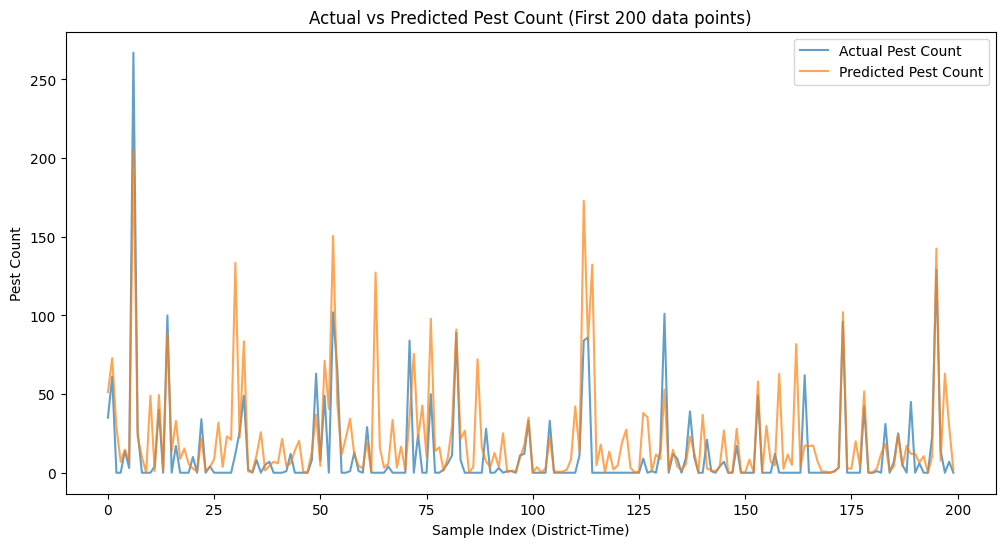

In [14]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
# from model_spatiotemporal_mpnn import SpatioTemporalMPNN  <-- REMOVE THIS IMPORT (Class is defined above)

# -----------------------------
# 1. Load Data Again
# -----------------------------
df = pd.read_csv("monthly_spatiotemporal_data.csv")
edge_index = torch.tensor(np.load("edge_index.npy"), dtype=torch.long)
edge_weight = torch.tensor(np.load("edge_weight.npy"), dtype=torch.float)

num_nodes = df["district_id"].nunique()

df = df.sort_values(["year_month", "district_id"])
months = df["year_month"].unique()
num_months = len(months)

# Recreate matrix
pest_matrix = np.zeros((num_months, num_nodes))

for i, month in enumerate(months):
    temp = df[df["year_month"] == month]
    pest_matrix[i, temp["district_id"].values] = temp["pest_count"].values

scaler = MinMaxScaler()
pest_matrix_scaled = scaler.fit_transform(pest_matrix)

pest_tensor = torch.tensor(pest_matrix_scaled, dtype=torch.float)

# -----------------------------
# 2. Prepare Test Data
# -----------------------------
window_size = 6
X_list = []
y_list = []

for i in range(num_months - window_size):
    X_list.append(pest_tensor[i:i+window_size])
    y_list.append(pest_tensor[i+window_size])

# -----------------------------
# If data is insufficient, handle gracefully
# -----------------------------
if len(X_list) == 0:
    print("Insufficient data for the window size.")
else:
    X = torch.stack(X_list).unsqueeze(-1) # [samples, time, nodes, 1]
    y = torch.stack(y_list)

    train_size = int(0.8 * X.shape[0])
    X_test = X[train_size:]
    y_test = y[train_size:]

    # -----------------------------
    # 3. Load Model
    # -----------------------------
    # Use the class DEFINED IN THIS NOTEBOOK
    # Ensure SpatioTemporalMPNN is available in the current namespace
    if 'SpatioTemporalMPNN' not in globals():
        print("Error: SpatioTemporalMPNN class not found. Please run the cell defining the model class above.")
    else: 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model = SpatioTemporalMPNN(
            num_nodes=num_nodes,
            in_channels=1,
            hidden_dim=32
        ).to(device)

        # Load the weights we just trained
        if os.path.exists("model.pth"):
            model.load_state_dict(torch.load("model.pth"))
            model.eval()

            # -----------------------------
            # 4. Generate Predictions
            # -----------------------------
            predictions = []

            with torch.no_grad():
                for i in range(X_test.shape[0]):
                    output = model(
                        X_test[i].to(device),
                        edge_index.to(device),
                        edge_weight.to(device)
                    )
                    predictions.append(output.cpu().numpy())

            predictions = np.array(predictions) # [test_samples, nodes]
            y_true = y_test.numpy()

            # -----------------------------
            # 5. Inverse Scaling (Standardization)
            # -----------------------------
            # We need to inverse transform (samples * nodes)
            # But scaler was fitted on (time * nodes), essentially column-wise for nodes.
            # The scaler expects shape (n_samples, num_nodes)

            # Inverse scaling
            # predictions shape: (n_samples, n_nodes) - same as what scaler expects
            pred_inv = scaler.inverse_transform(predictions)
            y_inv = scaler.inverse_transform(y_true)

            # Flatten for overall metrics
            pred_flat = pred_inv.flatten()
            y_flat = y_inv.flatten()

            # -----------------------------
            # 6. Metrics & Plotting
            # -----------------------------
            rmse = np.sqrt(mean_squared_error(y_flat, pred_flat))
            mae = mean_absolute_error(y_flat, pred_flat)
            r2 = r2_score(y_flat, pred_flat)

            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"R^2 Score: {r2:.4f}")

            plt.figure(figsize=(12, 6))
            plt.plot(y_flat[:200], label="Actual Pest Count", alpha=0.7)
            plt.plot(pred_flat[:200], label="Predicted Pest Count", alpha=0.7)
            plt.legend()
            plt.title("Actual vs Predicted Pest Count (First 200 data points)")
            plt.xlabel("Sample Index (District-Time)")
            plt.ylabel("Pest Count")
            plt.show()
        else:
            print("Model file 'model.pth' not found. Please run the training loop cell first.")

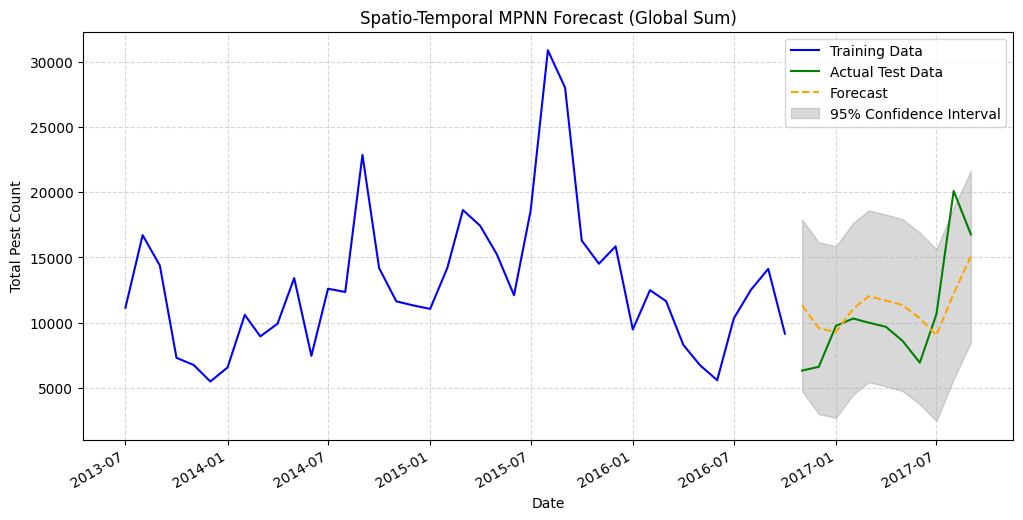

In [10]:
# -----------------------------
# 7. Visualization: Train, Test, and Predictions with CI
# -----------------------------
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# 1. Aggregate Data to Global Level
# We plot the sum of pest counts across all districts for each time step.
unique_months = df["year_month"].sort_values().unique()
unique_months_dt = pd.to_datetime(unique_months)

global_counts = []
for m in unique_months:
    val = df[df["year_month"] == m]["pest_count"].sum()
    global_counts.append(val)

global_counts = np.array(global_counts)

# -----------------------------
# 2. Get Preditions (Global)
# -----------------------------
# Re-ensure splits are correct
window_size = 6

# Total steps - window_size
effective_len = len(global_counts) - window_size
train_len = int(0.8 * effective_len)

# Target Dates (actual data we are trying to predict)
target_dates = unique_months_dt[window_size:]

train_dates = target_dates[:train_len]
test_dates = target_dates[train_len:]

# Ground Truth Split
y_train_global = global_counts[window_size : window_size + train_len]
y_test_global = global_counts[window_size + train_len :]

# Calculate Global Predictions
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train Preds
train_preds_global = []
with torch.no_grad():
    for i in range(X_train.shape[0]):
        out = model(X_train[i].to(device), edge_index.to(device), edge_weight.to(device))
        # Inverse transform: output is [nodes]
        # reshape to (1, nodes) for scaler
        node_preds = scaler.inverse_transform(out.cpu().numpy().reshape(1, -1))
        train_preds_global.append(np.sum(node_preds))

# Test Preds
test_preds_global = []
with torch.no_grad():
    for i in range(X_test.shape[0]):
        out = model(X_test[i].to(device), edge_index.to(device), edge_weight.to(device))
        node_preds = scaler.inverse_transform(out.cpu().numpy().reshape(1, -1))
        test_preds_global.append(np.sum(node_preds))

train_preds_global = np.array(train_preds_global)
test_preds_global = np.array(test_preds_global)

# -----------------------------
# 3. Calculate Confidence Interval
# -----------------------------
# Methodology from lstm.ipynb:
# residuals = y_test - predicted
# std_dev = np.std(residuals)
# CI = predicted +/- 1.96 * std_dev

# We use the residuals from the TEST set to estimate uncertainty
residuals = y_test_global[:len(test_preds_global)] - test_preds_global
std_dev = np.std(residuals)

upper_bound = test_preds_global + 1.96 * std_dev
lower_bound = test_preds_global - 1.96 * std_dev

# -----------------------------
# 4. Plot
# -----------------------------
plt.figure(figsize=(12, 6))

# Plot Actual Data (Split into Train and Test for clarity, or just one line)
# lstm.ipynb plotted "Training Data" and "Actual Test Data" separately
plt.plot(train_dates, y_train_global, label="Training Data", color='blue')
plt.plot(test_dates, y_test_global, label="Actual Test Data", color='green')

# Plot Forecast
plt.plot(test_dates, test_preds_global, label="Forecast", color='orange', linestyle='--')

# Plot CI
plt.fill_between(
    test_dates, 
    lower_bound, 
    upper_bound, 
    color='gray',
    alpha=0.3, 
    label=f'95% Confidence Interval'
)

plt.title("Spatio-Temporal MPNN Forecast (Global Sum)")
plt.xlabel("Date")
plt.ylabel("Total Pest Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.show()